In [1]:
## See how bad movement artifacts during optostim are

In [6]:
import numpy as np
from glob import glob
from fish.util.fileio import load_image
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
fnames = sorted(glob('/groups/ahrens/ahrenslab/davis/data/spim/raw/20171008/7dpf_cy171xec43_f2_opto_1_20171008_173349/TM*'))

In [54]:
from skimage.io import imread
ref = imread('/groups/ahrens/ahrenslab/davis/data/spim/proc/20171008/7dpf_cy171xec43_f2_opto_1_20171008_173349/reg/anat_reference.tif')

In [55]:
plr = slice(2000, 2200)
mxs = np.array([load_image(fn).max(0) for fn in fnames[plr]])

In [91]:
from fish.image.alignment import estimate_translation

In [95]:
%gui qt
import pyqtgraph as pq

In [98]:
pq.image(np.concatenate([moving, ref],1))

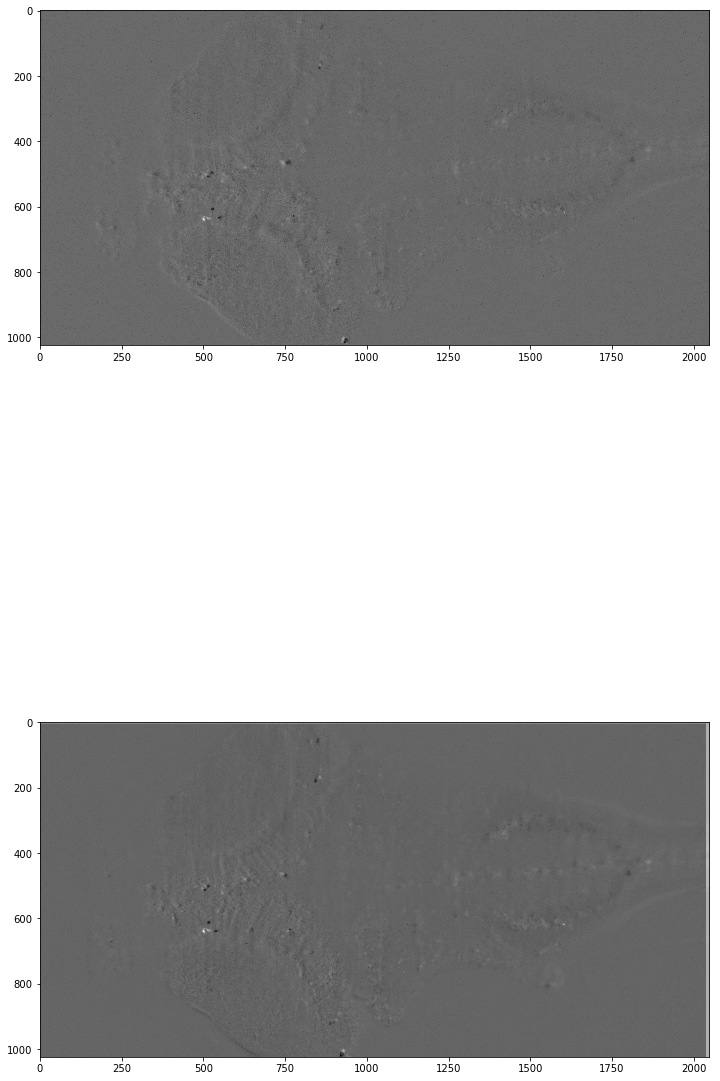

In [93]:
t = 2143
moving = load_image(fnames[t])
tx = estimate_translation(ref.max(0), moving.max(0))
fig, axs = plt.subplots(nrows=2, figsize=(12,24))
axs[0].imshow(ref.max(0) - moving.max(0), cmap='gray')
axs[1].imshow(ref.max(0) - tx.transform(moving.max(0)), cmap='gray')

In [1]:
## Reconstruct stimulated area from optostim experiments

In [1]:
from skimage.io import imread
paths = {}
paths['ephys'] = '/groups/ahrens/ahrenslab/davis/data/ephys/20171108/7dpf_cy171xec43_f1_opto_2_12mw.10chFlt'
paths['raw'] = '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171108/7dpf_cy171xec43_f1_opto_2_12mw_20171108_215904/'
paths['proc'] = paths['raw'].replace('raw', 'proc')
paths['reg'] = paths['proc'] + 'reg/'
paths['opto'] = paths['proc'] + 'opto_triggering/'
mask = imread(paths['opto'] + 'mask.tif')


In [2]:
from glob import glob
import numpy as np
patterns = np.array([imread(f) for f in sorted(glob('/groups/ahrens/ahrenslab/davis/data/ephys/20171108/7dpf_cy171xec43_f1/*.png'))])
anat = imread('/groups/ahrens/ahrenslab/davis/data/dmd_calibration/20171108/7dpf_cy171xec43_f1_anat_g_20171108_212622/TM00000_CM0_CHN00.tif').max(0)
dmd_rect = [229, 575, 1822, 1456]

In [9]:
def rgba_from_binary(mask):
    from numpy import zeros
    from skimage.color import grey2rgb
    from skimage.exposure import rescale_intensity
    output = zeros([*mask.shape, 4])
    output[:,:,:3] = grey2rgb(rescale_intensity(mask, out_range=(0,1)))
    output[:,:,3] = output[:,:,0]
    return output

def reverse_pattern(pattern, dmd_rect):
    from skimage.transform import resize
    from numpy import zeros
    full_cam = zeros([2048,2048])
 
    pattern_shape = (dmd_rect[3] - dmd_rect[1], dmd_rect[2] - dmd_rect[0])    
    resized=resize(pattern[:,::-1], output_shape=pattern_shape, preserve_range=True, mode='constant')    
    full_cam[dmd_rect[1]:dmd_rect[3], dmd_rect[0]:dmd_rect[2]] = resized
        
    return full_cam

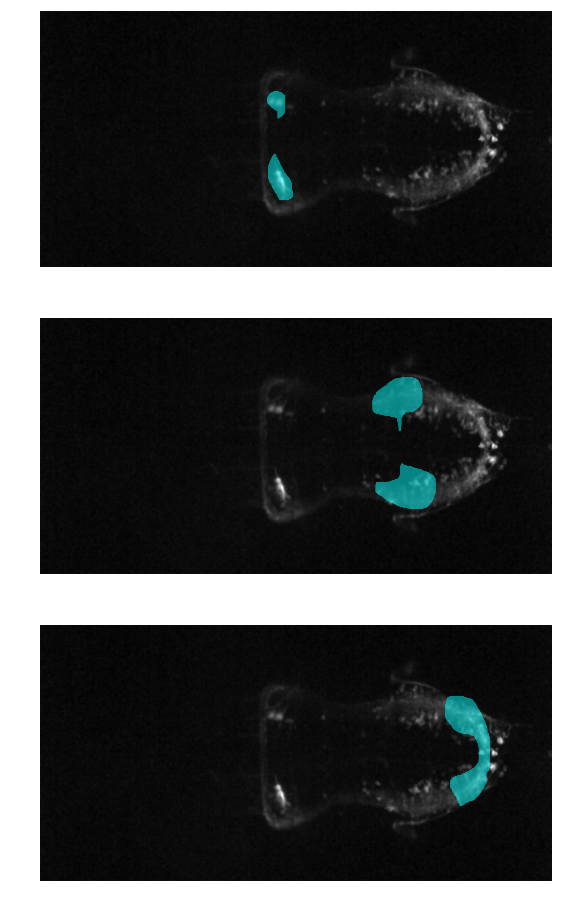

In [10]:
import matplotlib.pyplot as plt
from skimage.color import grey2rgb
from skimage.exposure import rescale_intensity
%matplotlib inline
anat_full = np.zeros([2048,2048,4])
from scipy.ndimage.filters import gaussian_filter
anat_filt = gaussian_filter(anat.astype('float'), [3,3])
anat_full[(2048//4):(3 * 2048 // 4),:,:3] = grey2rgb(rescale_intensity(anat_filt, out_range=(0,1)))
anat_full[:,:,-1] = 1
anat_full = adjust_gamma(anat_full, .8)
    
fig, axs = plt.subplots(nrows=patterns.shape[0], figsize=(16,16))
full_img = np.zeros(anat.shape)

from skimage.color import grey2rgb
from skimage.exposure import rescale_intensity
rgba_patterns = [rgba_from_binary(reverse_pattern(p, dmd_rect)) for p in patterns]
crop = (slice(2048 // 4, 3 * 2048 // 4), slice(0, None), slice(0, None))
for ind, ax in enumerate(axs):
    ax.imshow(anat_full[crop])
    ax.imshow(rgba_patterns[ind][crop] * np.array([0,1,1,.5]))
    ax.axis('off')